# Import MNIST Data

MNIST dataset is the one of the most popular datasets in machine learning, it represents the 'Hello, World!' of the datasets.
It holds the data of pictures of hand-written digits and its labels which is the digit that in that picture.
All pictures are 28 x 28 pixels which means each picture has 784 pixels flatten as the trainers.

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
X, y = np.array(mnist['data']), np.array(mnist['target'])
X.shape, y.shape

((70000, 784), (70000,))

### Show Sample of Data

Using `imshow` form `matplotlib` library we can show images.

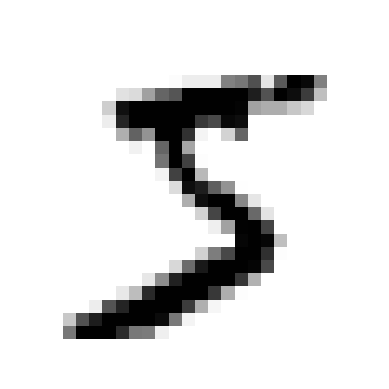

In [3]:
import matplotlib.pyplot as plt

plt.imshow(X[0].reshape(28, 28), cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

The target data are represented in string type, most of the machine learning algorithm assumes that the target will be a number.

In [5]:
y = y.astype(np.uint8)
y[0]

5

# Split Data to Train and Test

MNIST dataset already split into train and test, and it already shuffled also.
The train set has 60,000 instances, and the test set has 10,000 instances.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

# Train Machine Learning Model

For binary classification using `Stochastic Gradient Descent` is one of powerful solutions.

To examine this, let's convert our problem into binary class problem by make the model decide if the picture contains a givin digit or not.

In [7]:
from sklearn.linear_model import SGDClassifier

y_train_1, y_test_1 = (y_train == 1), (y_test == 1)
sgd_classifier_1 = SGDClassifier(random_state=42)
sgd_classifier_1.fit(X_train, y_train_1)

SGDClassifier(random_state=42)

In [8]:
sgd_classifier_1.predict([X[0]])

array([False])

In [9]:
y_train_5, y_test_5 = (y_train == 5), (y_test == 5)

sgd_classifier_5 = SGDClassifier(random_state=42)
sgd_classifier_5.fit(X_train, y_train_5)

sgd_classifier_5.predict([X[0]])

array([ True])

# Validate The Model

Unlike the regression problems, In classification validation is the most time consuming part of training the model. Let's have a look if this model performs well in the validation set.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def strat_K_folds(classifier, X, y):
    for train_index, test_index in skfold.split(X_train, y_train_1):
        clone_classifier = clone(classifier)
        X_train_folds = X[train_index]
        y_train_folds = y[train_index]
        X_test_fold = X[test_index]
        y_test_fold = y[test_index]
    
        clone_classifier.fit(X_train_folds, y_train_folds)
        y_pred = clone_classifier.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(n_correct / len(y_pred), end=', ')

strat_K_folds(sgd_classifier_1, X_train, y_train_1)

0.98845, 0.98695, 0.9851, 

In [11]:
strat_K_folds(sgd_classifier_5, X_train, y_train_5)

0.96025, 0.9691, 0.958, 

The previous function is doing almost the same as the `cross_val_score` function.

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier_1, X_train, y_train_1, cv=3, scoring='accuracy')

array([0.9878 , 0.98095, 0.99005])

In [13]:
cross_val_score(sgd_classifier_5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

That is looks great, The model predictions is above 98% accurate in predicting if the digit is 1 or not, and more than 95% in predicting the 5's.

But that is not the case, to show that let's make a model sets all predictions to be false.

In [14]:
from sklearn.base import BaseEstimator

class AlwaysFalseClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
false_classifier = AlwaysFalseClassifier()
cross_val_score(false_classifier, X_train, y_train_1, cv=3, scoring='accuracy')

array([0.88595, 0.8859 , 0.89105])

In [15]:
cross_val_score(false_classifier, X_train, y_train_1, cv=3, scoring='accuracy')

array([0.88595, 0.8859 , 0.89105])

As we expected, The model accuracy is more than 88% but it is actually broke, that is because the number of true values is much fewer than the false values, so the accuracy is not the best metric of this problem.

Confusion matrix gives classification problems different metrics to be evaluated with, these metrics calculated by giving weights to each possible actual outcome compared with every predicted outcome.

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import pandas as pd

y_train_pred_1 = cross_val_predict(sgd_classifier_1, X_train, y_train_1, cv=3)
confusion_matrix_1 = confusion_matrix(y_train_1, y_train_pred_1)

pd.DataFrame(confusion_matrix_1, columns=['predicted_no', 'predicted_yes'], index=['actual_no', 'actual_yes'])

,predicted_no,predicted_yes
actual_no,52917,341
actual_yes,483,6259


In [17]:
y_train_pred_5 = cross_val_predict(sgd_classifier_5, X_train, y_train_5, cv=3)
confusion_matrix_5 = confusion_matrix(y_train_5, y_train_pred_5)

pd.DataFrame(confusion_matrix_5, columns=['predicted_no', 'predicted_yes'], index=['actual_no', 'actual_yes'])

,predicted_no,predicted_yes
actual_no,53892,687
actual_yes,1891,3530


The confusion matrix gives a useful insights about model performance, but in some cases we need more concise metrics to evaluate your model.

One of these metrics called `Precision`, which shows the accuracy of the true predictions on the positive class.

Another metric is called `Recall`, which shows the accuracy of the true predictions on the positive and negative classes.

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_1 = precision_score(y_train_1, y_train_pred_1)
precision_5 = precision_score(y_train_5, y_train_pred_5)

recall_1 = recall_score(y_train_1, y_train_pred_1)
recall_5 = recall_score(y_train_5, y_train_pred_5)

print(f'Precision of 1\'s: {precision_1}, Recall of 1\'s: {recall_1}')
print(f'Precision of 5\'s: {precision_5}, Recall of 5\'s: {recall_5}')

Precision of 1's: 0.9483333333333334, Recall of 1's: 0.9283595372293089
Precision of 5's: 0.8370879772350012, Recall of 5's: 0.6511713705958311


That is looks more convenient than the accuracy. It's often to combine the precision and recall into F1 score which represents the weighted mean or harmonic mean.

In [19]:
from sklearn.metrics import f1_score

f1_1 = f1_score(y_train_1, y_train_pred_1)
f1_5 = f1_score(y_train_5, y_train_pred_5)

print(f'F1 Score For 1\'s: {f1_1}, F1 Score For 5\'s: {f1_5}')

F1 Score For 1's: 0.9382401439064608, F1 Score For 5's: 0.7325171197343847


The F1 score treats precision and recall the same, but in some cases you might prefer the precision over the recall or another cases the opposite happens when you prefer the recall over the precision thats called the precision recall trade-off.